In [11]:
cd C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis\

C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis


In [12]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import display
from sys import getsizeof
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# storing data directories for this notebook.
img_out_dir = 'data/images/EDA_NB1/'
data_out_dir = 'data/pickled/EDA_NB1/'

# used to print word cloud in twitter bird shape.
from PIL import Image
wc_image_mask = np.array(Image.open('data/twitter.png'))

%matplotlib inline

## Airline Sentiment Classification

Dataset Description from Kaggle:<br>
Classifies customer sentiment towards major U.S. airlines, based on twitter data. Tweets were scraped from February of 2015 and contributors were asked to classify tweets by positive, negative, and neutral categories, followed by categorizing negative reasons (such as “late flight” or “rude service”).

The Kaggle Dataset contains tweets and categories for 14,640k airline related tweets, classified into one of 3 sentiment categories (positive, negative, neutral). 
<br>Let's see if I can accurately classify the tweet sentiment category based on the text.

1. Load the data
2. Explore and clean the data:
  1. Standardize case (lower or upper?)
  2. Remove stop words
  3. Lemmatize or stem

### EDA on first 8000 rows of dataset. Had to split rows since calculating the sum of the columns<br>used to kill the kernel.

In [13]:
# reading in 8000 rows but dataset has 14640. I get performance issues.

In [14]:
air_full_df = pd.read_csv("data/csvfiles/kaggle_airline_dataset.csv", encoding='utf-8',nrows=8000)

In [15]:
air_full_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [16]:
# data size of full kaggle dataset.
air_full_df.shape

(8000, 15)

In [17]:
air_full_df.columns

Index([u'tweet_id', u'airline_sentiment', u'airline_sentiment_confidence',
       u'negativereason', u'negativereason_confidence', u'airline',
       u'airline_sentiment_gold', u'name', u'negativereason_gold',
       u'retweet_count', u'text', u'tweet_coord', u'tweet_created',
       u'tweet_location', u'user_timezone'],
      dtype='object')

In [18]:
air_full_df.airline_sentiment.value_counts()

negative    4560
neutral     1954
positive    1486
Name: airline_sentiment, dtype: int64

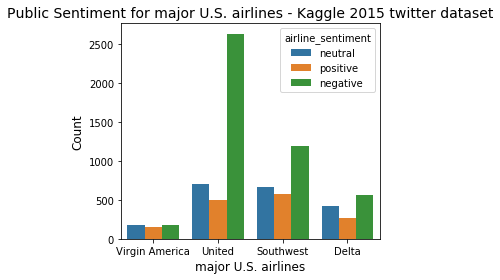

In [19]:
# Airline sentiment.
sns.countplot(x="airline", hue="airline_sentiment", data=air_full_df)
plt.title('Public Sentiment for major U.S. airlines - Kaggle 2015 twitter dataset',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_airline_sentiment_hist.png')

In [20]:
# What are reasons for customer dissatisfaction?
# Explore this to make recommendations at the end from findings.

In [21]:
# plot negative reason value_counts.
neg_reason = air_full_df.negativereason[air_full_df.negativereason.notnull()]
neg_reason.value_counts()

Customer Service Issue         1233
Late Flight                     864
Can't Tell                      680
Lost Luggage                    396
Cancelled Flight                384
Bad Flight                      362
Flight Booking Problems         258
Flight Attendant Complaints     250
longlines                        92
Damaged Luggage                  41
Name: negativereason, dtype: int64

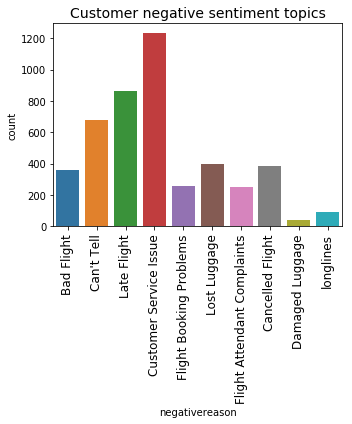

In [22]:
plt.figure(figsize=(5,6))
sns.countplot(x="negativereason", data=air_full_df)
plt.grid(0)
plt.xticks(rotation = 90, fontsize=12)
plt.title("Customer negative sentiment topics", fontsize=14)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_customer_neg_sent_topics_hist.png')

In [23]:
# airlines 
air_full_df.airline.unique()

array([u'Virgin America', u'United', u'Southwest', u'Delta'], dtype=object)

In [24]:
# data types
air_full_df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [25]:
# check for null values.
air_full_df.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  3440
negativereason_confidence       2628
airline                            0
airline_sentiment_gold          7983
name                               0
negativereason_gold             7987
retweet_count                      0
text                               0
tweet_coord                     7388
tweet_created                      0
tweet_location                  2478
user_timezone                   2536
dtype: int64

In [26]:
# get subset with cols = ['airline', 'text', 'airline_sentiment', 'airline_sentiment:confidence']

In [27]:
sub_cols = ['text', 'airline_sentiment', 'airline_sentiment_confidence', 
            'negativereason', 'airline']
air_sub_df = air_full_df.loc[:, sub_cols]

In [28]:
del air_full_df

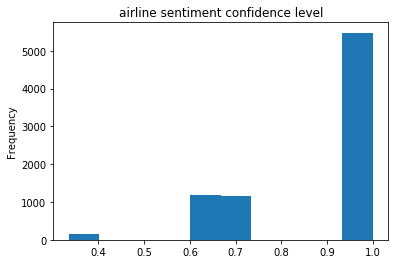

In [29]:
# look at the confidence of values for the 3 categories.
air_sub_df.airline_sentiment_confidence.plot(kind='hist', title='airline sentiment confidence level')
plt.grid(0)

In [30]:
# let's only keep tweets where the airline_sentiment_confidence is > 0.7

In [31]:
mask = air_sub_df.airline_sentiment_confidence >= 0.7

air_sub_df = air_sub_df.loc[mask,:]

In [32]:
# dataframe with airline sentiment data with 
air_sub_df.shape

(5656, 5)

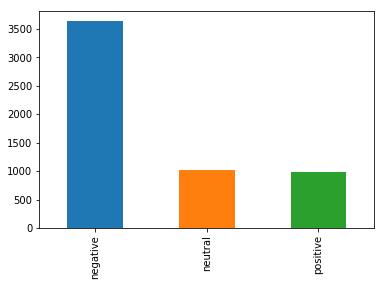

In [33]:
# look at the count of values for the 3 categories.
air_sub_df.airline_sentiment.value_counts().plot(kind='bar')
plt.grid(0)

In [34]:
air_sub_df.head()

text airline_sentiment  \
0                @VirginAmerica What @dhepburn said.           neutral   
3  @VirginAmerica it's really aggressive to blast...          negative   
4  @VirginAmerica and it's a really big bad thing...          negative   
5  @VirginAmerica seriously would pay $30 a fligh...          negative   
9  @VirginAmerica it was amazing, and arrived an ...          positive   

   airline_sentiment_confidence negativereason         airline  
0                           1.0            NaN  Virgin America  
3                           1.0     Bad Flight  Virgin America  
4                           1.0     Can't Tell  Virgin America  
5                           1.0     Can't Tell  Virgin America  
9                           1.0            NaN  Virgin America

In [35]:
air_sub_df.iloc[1,0]

u'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

In [36]:
air_sub_df[air_sub_df.airline_sentiment == 'positive']['text'][:10]

9     @VirginAmerica it was amazing, and arrived an ...
11    @VirginAmerica I &lt;3 pretty graphics. so muc...
12    @VirginAmerica This is such a great deal! Alre...
14                               @VirginAmerica Thanks!
16    @VirginAmerica So excited for my first cross c...
18                     I ❤️ flying @VirginAmerica. ☺️👍
19    @VirginAmerica you know what would be amazingl...
21    @VirginAmerica I love this graphic. http://t.c...
22    @VirginAmerica I love the hipster innovation. ...
34    @VirginAmerica this is great news!  America co...
Name: text, dtype: object

In [37]:
air_sub_df[air_sub_df.airline_sentiment == 'negative']['text'][:10]

3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
17    @VirginAmerica  I flew from NYC to SFO last we...
24    @VirginAmerica you guys messed up my seating.....
25    @VirginAmerica status match program.  I applie...
26    @VirginAmerica What happened 2 ur vegan food o...
28    @VirginAmerica amazing to me that we can't get...
30    @VirginAmerica hi! I just bked a cool birthday...
32    @VirginAmerica help, left expensive headphones...
Name: text, dtype: object

In [38]:
air_sub_df[air_sub_df.airline_sentiment == 'neutral']['text'][:10]

0                   @VirginAmerica What @dhepburn said.
23    @VirginAmerica will you be making BOS&gt;LAS n...
31    @VirginAmerica Are the hours of operation for ...
42    @VirginAmerica plz help me win my bid upgrade ...
44    @VirginAmerica are flights leaving Dallas for ...
48    @VirginAmerica @ladygaga @carrieunderwood Afte...
52    @VirginAmerica wish you flew out of Atlanta......
53    @VirginAmerica @ladygaga @carrieunderwood Juli...
54    @VirginAmerica Will flights be leaving Dallas ...
58    @VirginAmerica @ladygaga @carrieunderwood - Ca...
Name: text, dtype: object

In [39]:
# target.
y = air_sub_df['airline_sentiment']

In [40]:
# unique values of y.
y.unique()

array([u'neutral', u'negative', u'positive'], dtype=object)

In [41]:
#*********** Let's try to look at the top words in each of the categories, using CountVectorizer() *************

In [42]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [43]:
from nltk.stem.porter import PorterStemmer
import string

In [44]:
# exclude name of airlines from the tweets. 
exclude = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways',
           'americanair', 'jetblue', 'southwest', 'flight', 'flights',
           'URL', 'AT_USER', 'amp', 'amp;', '&amp;']

In [45]:
# define stop words. Use the defined 'english' stop words. I will add the airline names to that.
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(exclude)
exclude_punctuation = set(string.punctuation) 

In [46]:
def tokenize(text):
    return(text.split())

In [47]:
def cleaner(text):
    
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean
    text = re.sub('&#39;','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [48]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    token_text = tokenize(text)
    text = ' '.join(i for i in token_text if (i not in stop_words))
    
    return(text)

In [49]:
def stemming(text):
    '''
    eliminate plurals and redundancy of words (ie thank, thanks)
    '''
    ps = PorterStemmer()
    text = tokenize(text)
    text = ' '.join(ps.stem(word) for word in text)
    return(text)

In [50]:
def declump_emojis(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            print(i)
            em_txt = em_txt.replace(i,' '+i+' ')
        
    return(em_txt)

## Clean Text
```(eliminate web tags, punctuation, symbols...)```

In [51]:
air_sub_df.columns

Index([u'text', u'airline_sentiment', u'airline_sentiment_confidence',
       u'negativereason', u'airline'],
      dtype='object')

In [52]:
# create a new category 'clean_text' with clean text.
air_sub_df['clean_text'] = air_sub_df['text'].apply(cleaner)

In [53]:
# Let's see what the clean data looks like.

In [54]:
air_sub_df[['clean_text', 'text']][y=='positive'][:10]

clean_text  \
9   it was amazing and arrived an hour early youre...   
11  i lt3 pretty graphics so much better than mini...   
12  this is such a great deal already thinking abo...   
14                                             thanks   
16  so excited for my first cross country flight l...   
18                                   i ❤️ flying ☺️👍   
19  you know what would be amazingly awesome bosfl...   
21                                i love this graphic   
22  i love the hipster innovation you are a feel g...   
34  this is great news america could start flights...   

                                                 text  
9   @VirginAmerica it was amazing, and arrived an ...  
11  @VirginAmerica I &lt;3 pretty graphics. so muc...  
12  @VirginAmerica This is such a great deal! Alre...  
14                             @VirginAmerica Thanks!  
16  @VirginAmerica So excited for my first cross c...  
18                   I ❤️ flying @VirginAmerica. ☺️👍  
19  @VirginAmerica you know what would be amazingl...  
21  @VirginAmerica I love this graphic. http://t.c...  
22  @VirginAmerica I love the hipster innovation. ...  
34  @VirginAmerica this is great news!  America co...

In [55]:
air_sub_df.loc[19, 'text']

u'@VirginAmerica you know what would be amazingly awesome? BOS-FLL PLEASE!!!!!!! I want to fly with only you.'

In [56]:
air_sub_df.loc[19, 'clean_text']

u'you know what would be amazingly awesome bosfll please i want to fly with only you'

In [57]:
air_sub_df[['clean_text', 'text']][y=='negative'][:10]

clean_text  \
3   its really aggressive to blast obnoxious enter...   
4             and its a really big bad thing about it   
5   seriously would pay 30 a flight for seats that...   
17  i flew from nyc to sfo last week and couldnt f...   
24  you guys messed up my seating i reserved seati...   
25  status match program i applied and its been th...   
26  what happened 2 ur vegan food options at least...   
28  amazing to me that we cant get any cold air fr...   
30  hi i just bked a cool birthday trip with you b...   
32  help left expensive headphones on flight 89 ia...   

                                                 text  
3   @VirginAmerica it's really aggressive to blast...  
4   @VirginAmerica and it's a really big bad thing...  
5   @VirginAmerica seriously would pay $30 a fligh...  
17  @VirginAmerica  I flew from NYC to SFO last we...  
24  @VirginAmerica you guys messed up my seating.....  
25  @VirginAmerica status match program.  I applie...  
26  @VirginAmerica What happened 2 ur vegan food o...  
28  @VirginAmerica amazing to me that we can't get...  
30  @VirginAmerica hi! I just bked a cool birthday...  
32  @VirginAmerica help, left expensive headphones...

In [58]:
air_sub_df.loc[28, 'text']

u"@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS"

In [59]:
air_sub_df.loc[28, 'clean_text']

u'amazing to me that we cant get any cold air from the vents vx358 noair worstflightever roasted sfotobos'

In [60]:
air_sub_df[['clean_text', 'text']][y=='neutral'][:10]

clean_text  \
0                                           what said   
23  will you be making bosgtlas non stop permanent...   
31  are the hours of operation for the club at sfo...   
42  plz help me win my bid upgrade for my flight 2...   
44  are flights leaving dallas for seattle on time...   
48  after last night tribute soundofmusic oscars20...   
52                  wish you flew out of atlanta soon   
53                           julie andrews hands down   
54  will flights be leaving dallas for la on febru...   
58                                             carrie   

                                                 text  
0                 @VirginAmerica What @dhepburn said.  
23  @VirginAmerica will you be making BOS&gt;LAS n...  
31  @VirginAmerica Are the hours of operation for ...  
42  @VirginAmerica plz help me win my bid upgrade ...  
44  @VirginAmerica are flights leaving Dallas for ...  
48  @VirginAmerica @ladygaga @carrieunderwood Afte...  
52  @VirginAmerica wish you flew out of Atlanta......  
53  @VirginAmerica @ladygaga @carrieunderwood Juli...  
54  @VirginAmerica Will flights be leaving Dallas ...  
58  @VirginAmerica @ladygaga @carrieunderwood - Ca...

In [61]:
air_sub_df.loc[48, 'text']

u'@VirginAmerica @ladygaga @carrieunderwood After last night #tribute #SoundOfMusic #Oscars2015 @ladygaga! I think @carrieunderwood agree'

In [62]:
air_sub_df.loc[48, 'clean_text']

u'after last night tribute soundofmusic oscars2015 i think agree'

## Reduce dimensionality - using english stop words
```(eliminating english stop words that typically don't impart much meaning like prepositions, pronouns... I will also remove twitter handle and urls encoded above, in the cleaner method, as AT_USER and URL.```

In [63]:
# create a new category 'stopw_clean_text' to store reduced dimensionality text,
# by eliminating english stop words.
air_sub_df['stopw_clean_text'] = air_sub_df['clean_text'].apply(remove_stopwords)

In [64]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='positive'][:10]

stopw_clean_text  \
9               amazing arrived hour early youre good   
11   lt3 pretty graphics better minimal iconography d   
12  great deal thinking 2nd trip havent gone 1st t...   
14                                             thanks   
16  excited cross country lax mco ive heard great ...   
18                                     ❤️ flying ☺️👍   
19             know amazingly awesome bosfll want fly   
21                                       love graphic   
22            love hipster innovation feel good brand   
34           great news america start hawaii end year   

                                           clean_text  
9   it was amazing and arrived an hour early youre...  
11  i lt3 pretty graphics so much better than mini...  
12  this is such a great deal already thinking abo...  
14                                             thanks  
16  so excited for my first cross country flight l...  
18                                   i ❤️ flying ☺️👍  
19  you know what would be amazingly awesome bosfl...  
21                                i love this graphic  
22  i love the hipster innovation you are a feel g...  
34  this is great news america could start flights...

In [65]:
air_sub_df.loc[19, 'clean_text']

u'you know what would be amazingly awesome bosfll please i want to fly with only you'

In [66]:
air_sub_df.loc[19, 'stopw_clean_text']

u'know amazingly awesome bosfll want fly'

In [67]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='negative'][:10]

stopw_clean_text  \
3   really aggressive blast obnoxious entertainmen...   
4                                really big bad thing   
5   seriously pay 30 seats didnt playing really ba...   
17  flew nyc sfo week fully sit seat large gentlem...   
24  guys messed seating reserved seating friends g...   
25  status match program applied weeks called emai...   
26  happened 2 ur vegan food options say ur site k...   
28  amazing cold air vents vx358 noair worstflight...   
30  hi just bked cool birthday trip add elevate ca...   
32  help left expensive headphones 89 iad lax toda...   

                                           clean_text  
3   its really aggressive to blast obnoxious enter...  
4             and its a really big bad thing about it  
5   seriously would pay 30 a flight for seats that...  
17  i flew from nyc to sfo last week and couldnt f...  
24  you guys messed up my seating i reserved seati...  
25  status match program i applied and its been th...  
26  what happened 2 ur vegan food options at least...  
28  amazing to me that we cant get any cold air fr...  
30  hi i just bked a cool birthday trip with you b...  
32  help left expensive headphones on flight 89 ia...

In [68]:
air_sub_df.loc[28, 'clean_text']

u'amazing to me that we cant get any cold air from the vents vx358 noair worstflightever roasted sfotobos'

In [69]:
air_sub_df.loc[28, 'stopw_clean_text']

u'amazing cold air vents vx358 noair worstflightever roasted sfotobos'

In [70]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='neutral'][:10]

stopw_clean_text  \
0                                                said   
23  making bosgtlas non stop permanently anytime soon   
31     hours operation club sfo posted online current   
42     plz help win bid upgrade 227 laxgtsea 🍷👍💺✈️   
44                 leaving dallas seattle time feb 24   
48  night tribute soundofmusic oscars2015 think agree   
52                             wish flew atlanta soon   
53                                julie andrews hands   
54                    leaving dallas la february 24th   
58                                             carrie   

                                           clean_text  
0                                           what said  
23  will you be making bosgtlas non stop permanent...  
31  are the hours of operation for the club at sfo...  
42  plz help me win my bid upgrade for my flight 2...  
44  are flights leaving dallas for seattle on time...  
48  after last night tribute soundofmusic oscars20...  
52                  wish you flew out of atlanta soon  
53                           julie andrews hands down  
54  will flights be leaving dallas for la on febru...  
58                                             carrie

In [71]:
air_sub_df.loc[48, 'clean_text']

u'after last night tribute soundofmusic oscars2015 i think agree'

In [72]:
air_sub_df.loc[48, 'stopw_clean_text']

u'night tribute soundofmusic oscars2015 think agree'

## Further reduce dimensionality - using stemming 
```(Stemming attempts to find the root of the word by chopping off the end, like thanks becoms thank...)```

In [73]:
# create a new category 'stem_stopw_clean_text' to store reduced dimensionality text,
# by finding root of words.
air_sub_df['stem_stopw_clean_text'] = air_sub_df['stopw_clean_text'].apply(stemming)

In [74]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='positive'][:10]

stem_stopw_clean_text  \
9                     amaz arriv hour earli your good   
11      lt3 pretti graphic better minim iconographi d   
12   great deal think 2nd trip havent gone 1st trip p   
14                                              thank   
16  excit cross countri lax mco ive heard great th...   
18                                        ❤️ fli ☺️👍   
19              know amazingli awesom bosfll want fli   
21                                       love graphic   
22                 love hipster innov feel good brand   
34           great news america start hawaii end year   

                                     stopw_clean_text  
9               amazing arrived hour early youre good  
11   lt3 pretty graphics better minimal iconography d  
12  great deal thinking 2nd trip havent gone 1st t...  
14                                             thanks  
16  excited cross country lax mco ive heard great ...  
18                                     ❤️ flying ☺️👍  
19             know amazingly awesome bosfll want fly  
21                                       love graphic  
22            love hipster innovation feel good brand  
34           great news america start hawaii end year

In [75]:
air_sub_df.loc[19, 'stopw_clean_text']

u'know amazingly awesome bosfll want fly'

In [76]:
air_sub_df.loc[19, 'stem_stopw_clean_text']

u'know amazingli awesom bosfll want fli'

In [77]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='negative'][:10]

stem_stopw_clean_text  \
3   realli aggress blast obnoxi entertain guest fa...   
4                                realli big bad thing   
5   serious pay 30 seat didnt play realli bad thin...   
17  flew nyc sfo week fulli sit seat larg gentlema...   
24  guy mess seat reserv seat friend guy gave seat...   
25  statu match program appli week call email respons   
26  happen 2 ur vegan food option say ur site know...   
28  amaz cold air vent vx358 noair worstflightev r...   
30  hi just bked cool birthday trip add elev caus ...   
32  help left expens headphon 89 iad lax today sea...   

                                     stopw_clean_text  
3   really aggressive blast obnoxious entertainmen...  
4                                really big bad thing  
5   seriously pay 30 seats didnt playing really ba...  
17  flew nyc sfo week fully sit seat large gentlem...  
24  guys messed seating reserved seating friends g...  
25  status match program applied weeks called emai...  
26  happened 2 ur vegan food options say ur site k...  
28  amazing cold air vents vx358 noair worstflight...  
30  hi just bked cool birthday trip add elevate ca...  
32  help left expensive headphones 89 iad lax toda...

In [78]:
air_sub_df.loc[28, 'stopw_clean_text']

u'amazing cold air vents vx358 noair worstflightever roasted sfotobos'

In [79]:
air_sub_df.loc[28, 'stem_stopw_clean_text']

u'amaz cold air vent vx358 noair worstflightev roast sfotobo'

In [80]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='neutral'][:10]

stem_stopw_clean_text  \
0                                            said   
23       make bosgtla non stop perman anytim soon   
31          hour oper club sfo post onlin current   
42  plz help win bid upgrad 227 laxgtsea 🍷👍💺✈️   
44                  leav dalla seattl time feb 24   
48  night tribut soundofmus oscars2015 think agre   
52                         wish flew atlanta soon   
53                               juli andrew hand   
54                    leav dalla la februari 24th   
58                                          carri   

                                     stopw_clean_text  
0                                                said  
23  making bosgtlas non stop permanently anytime soon  
31     hours operation club sfo posted online current  
42     plz help win bid upgrade 227 laxgtsea 🍷👍💺✈️  
44                 leaving dallas seattle time feb 24  
48  night tribute soundofmusic oscars2015 think agree  
52                             wish flew atlanta soon  
53                                julie andrews hands  
54                    leaving dallas la february 24th  
58                                             carrie

In [81]:
air_sub_df.loc[48, 'stopw_clean_text']

u'night tribute soundofmusic oscars2015 think agree'

In [82]:
air_sub_df.loc[48, 'stem_stopw_clean_text']

u'night tribut soundofmus oscars2015 think agre'

In [83]:
# Let's make a word cloud to visualize the clean text data.

In [137]:
def make_wordcloud(data, title, filename, mask):
    plt.figure(figsize=(7,7))
    im = WordCloud(max_words=300, mask=mask).generate(' '.join(i for i in data))
    plt.grid(0)
    plt.title(title, fontsize=14)
    im.to_file(img_out_dir+filename)
    plt.imshow(im)

## Positive class

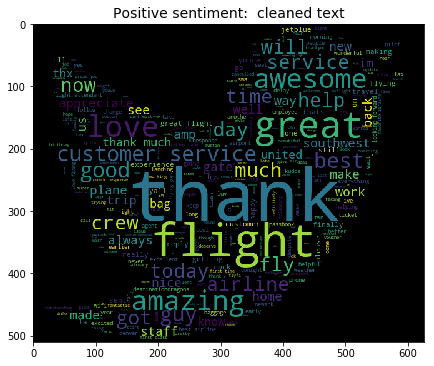

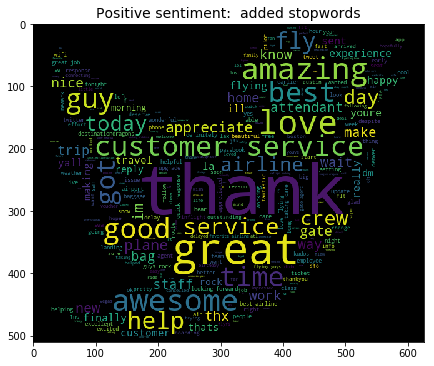

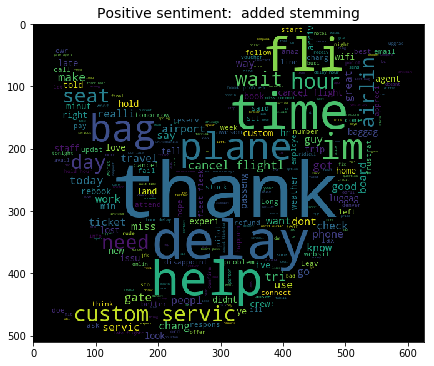

In [138]:
# twitter logo.
mask = wc_image_mask

# only cleaned text.
data = air_sub_df['clean_text'][y=='positive']
title = "Positive sentiment:  cleaned text"
filename = 'WordCld_pos_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stopwords"
filename = 'WordCld_pos_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text']
title = "Positive sentiment:  added stemming"
filename = 'WordCld_pos_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Negative class

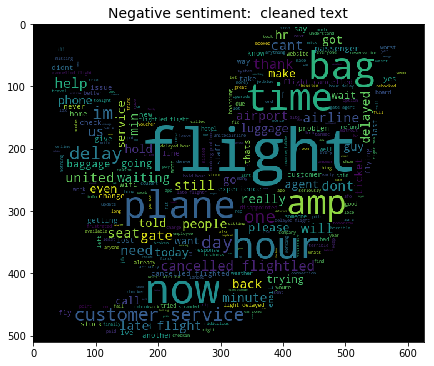

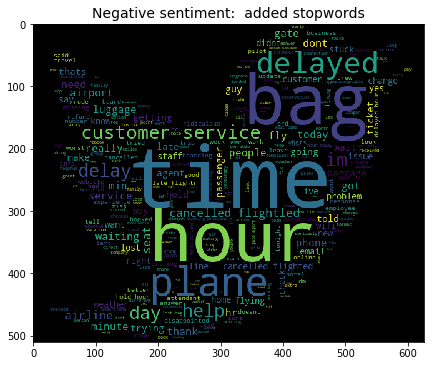

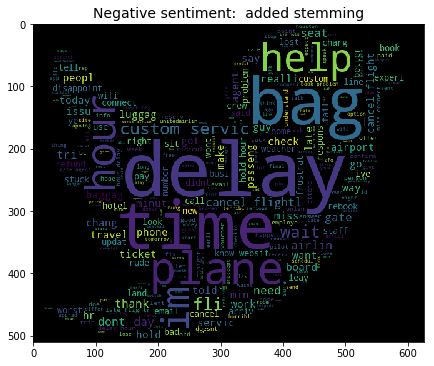

In [88]:
# only cleaned text.
data = air_sub_df['clean_text'][y=='negative']
title = "Negative sentiment:  cleaned text"
filename = 'WordCld_neg_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stopwords"
filename = 'WordCld_neg_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stemming"
filename = 'WordCld_neg_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

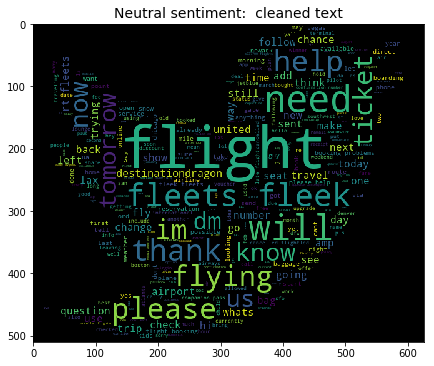

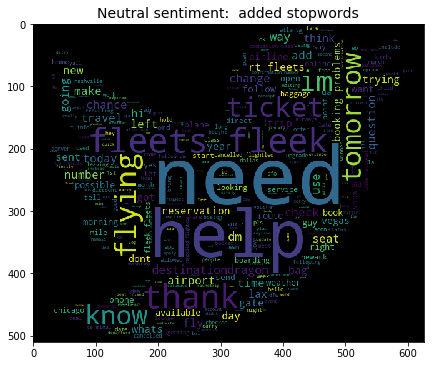

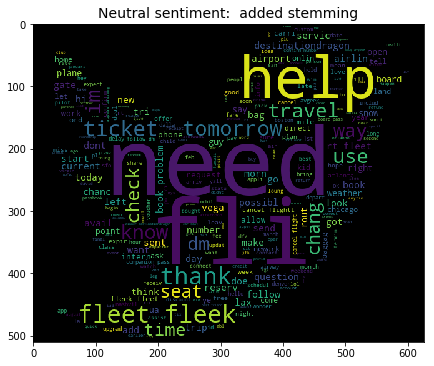

In [89]:
# only cleaned text.
data = air_sub_df['clean_text'][y=='neutral']
title = "Neutral sentiment:  cleaned text"
filename = 'WordCld_neut_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stopwords"
filename = 'WordCld_neut_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stemming"
filename = 'WordCld_neut_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Feature extraction using CountVectorizer() 
```compare results of using 'stemming' and 'not using stemming'.```

## Look at uni-grams 

In [90]:
grams = "Unigrams"

In [91]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(1,1))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(1,1))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(1,1))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y


In [92]:
print(words_df.shape)
words_df.head(4)

(5656, 8556)


0162431184663  0167560070877  0214  021mbps  02272015  03  \
airline_sentiment                                                              
neutral                        0              0     0        0         0   0   
negative                       0              0     0        0         0   0   
negative                       0              0     0        0         0   0   
negative                       0              0     0        0         0   0   

                   0510  0530  0769  10   ...    zcc82u  zero  zippers  \
airline_sentiment                         ...                            
neutral               0     0     0   0   ...         0     0        0   
negative              0     0     0   0   ...         0     0        0   
negative              0     0     0   0   ...         0     0        0   
negative              0     0     0   0   ...         0     0        0   

                   zombie  zone  zones  zoom  zrh  zukes  zurich  
airline_sentiment                                                 
neutral                 0     0      0     0    0      0       0  
negative                0     0      0     0    0      0       0  
negative                0     0      0     0    0      0       0  
negative                0     0      0     0    0      0       0  

[4 rows x 8556 columns]

In [93]:
print(words_stop_df.shape)
words_stop_df.head(4)

(5656, 8296)


0162431184663  0167560070877  0214  021mbps  02272015  03  \
airline_sentiment                                                              
neutral                        0              0     0        0         0   0   
negative                       0              0     0        0         0   0   
negative                       0              0     0        0         0   0   
negative                       0              0     0        0         0   0   

                   0510  0530  0769  10   ...    zcc82u  zero  zippers  \
airline_sentiment                         ...                            
neutral               0     0     0   0   ...         0     0        0   
negative              0     0     0   0   ...         0     0        0   
negative              0     0     0   0   ...         0     0        0   
negative              0     0     0   0   ...         0     0        0   

                   zombie  zone  zones  zoom  zrh  zukes  zurich  
airline_sentiment                                                 
neutral                 0     0      0     0    0      0       0  
negative                0     0      0     0    0      0       0  
negative                0     0      0     0    0      0       0  
negative                0     0      0     0    0      0       0  

[4 rows x 8296 columns]

In [94]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5656, 6725)


0162431184663  0167560070877  0214  021mbp  02272015  03  \
airline_sentiment                                                             
neutral                        0              0     0       0         0   0   
negative                       0              0     0       0         0   0   
negative                       0              0     0       0         0   0   
negative                       0              0     0       0         0   0   

                   0510  0530  0769  10   ...    yyzua70435  zcc82u  zero  \
airline_sentiment                         ...                               
neutral               0     0     0   0   ...             0       0     0   
negative              0     0     0   0   ...             0       0     0   
negative              0     0     0   0   ...             0       0     0   
negative              0     0     0   0   ...             0       0     0   

                   zipper  zombi  zone  zoom  zrh  zuke  zurich  
airline_sentiment                                                
neutral                 0      0     0     0    0     0       0  
negative                0      0     0     0    0     0       0  
negative                0      0     0     0    0     0       0  
negative                0      0     0     0    0     0       0  

[4 rows x 6725 columns]

In [95]:
# We see that the dimensions of the features reduced from 7904 with clean text, 
# to 7827 with stopwords and 7264 with stemming.

### Positive Sentiment

In [96]:
def disp_positive_grams(words_df, words_stop_df, words_stem_df, grams):
    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "positive"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)


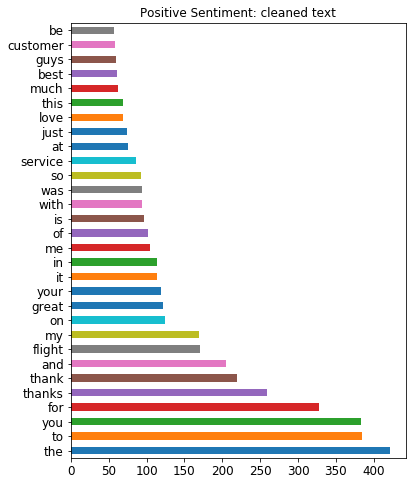

Index([u'the', u'to', u'you', u'for', u'thanks', u'thank', u'and', u'flight',
       u'my', u'on', u'great', u'your', u'it', u'in', u'me', u'of', u'is',
       u'with', u'was', u'so', u'service', u'at', u'just', u'love', u'this',
       u'much', u'best', u'guys', u'customer', u'be'],
      dtype='object')


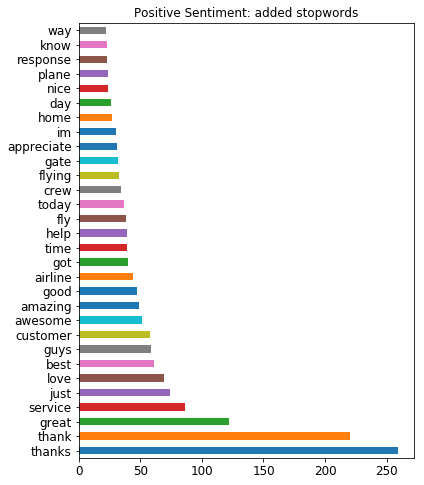

Index([u'thanks', u'thank', u'great', u'service', u'just', u'love', u'best',
       u'guys', u'customer', u'awesome', u'amazing', u'good', u'airline',
       u'got', u'time', u'help', u'fly', u'today', u'crew', u'flying', u'gate',
       u'appreciate', u'im', u'home', u'day', u'nice', u'plane', u'response',
       u'know', u'way'],
      dtype='object')


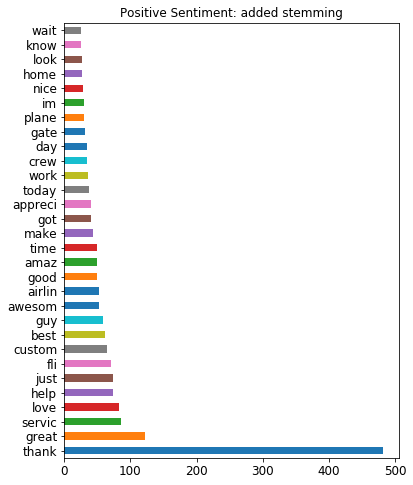

Index([u'thank', u'great', u'servic', u'love', u'help', u'just', u'fli',
       u'custom', u'best', u'guy', u'awesom', u'airlin', u'good', u'amaz',
       u'time', u'make', u'got', u'appreci', u'today', u'work', u'crew',
       u'day', u'gate', u'plane', u'im', u'nice', u'home', u'look', u'know',
       u'wait'],
      dtype='object')


In [97]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [98]:
def disp_negative_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "negative"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

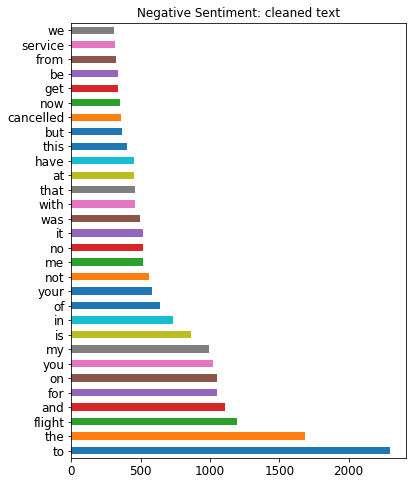

Index([u'to', u'the', u'flight', u'and', u'for', u'on', u'you', u'my', u'is',
       u'in', u'of', u'your', u'not', u'me', u'no', u'it', u'was', u'with',
       u'that', u'at', u'have', u'this', u'but', u'cancelled', u'now', u'get',
       u'be', u'from', u'service', u'we'],
      dtype='object')


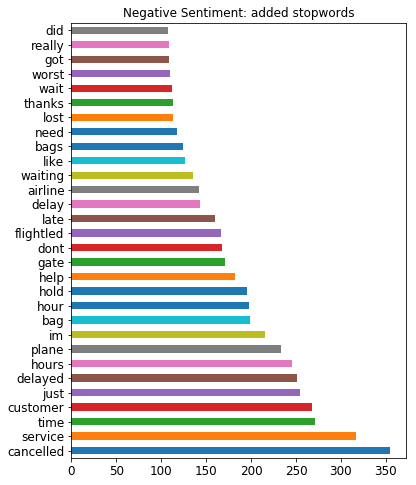

Index([u'cancelled', u'service', u'time', u'customer', u'just', u'delayed',
       u'hours', u'plane', u'im', u'bag', u'hour', u'hold', u'help', u'gate',
       u'dont', u'flightled', u'late', u'delay', u'airline', u'waiting',
       u'like', u'bags', u'need', u'lost', u'thanks', u'wait', u'worst',
       u'got', u'really', u'did'],
      dtype='object')


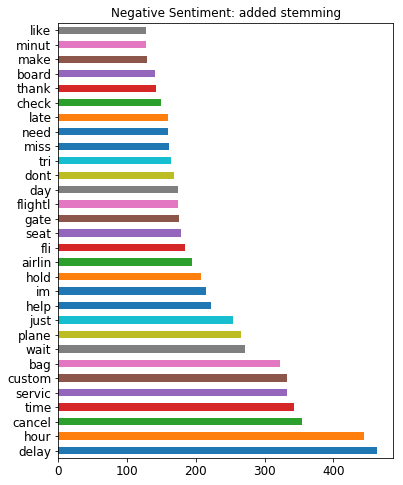

Index([u'delay', u'hour', u'cancel', u'time', u'servic', u'custom', u'bag',
       u'wait', u'plane', u'just', u'help', u'im', u'hold', u'airlin', u'fli',
       u'seat', u'gate', u'flightl', u'day', u'dont', u'tri', u'miss', u'need',
       u'late', u'check', u'thank', u'board', u'make', u'minut', u'like'],
      dtype='object')


In [99]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [100]:
def disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "neutral"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

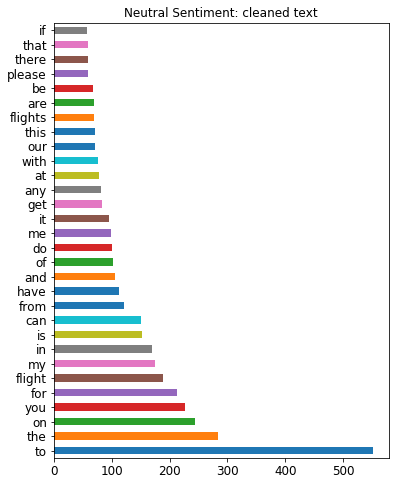

Index([u'to', u'the', u'on', u'you', u'for', u'flight', u'my', u'in', u'is',
       u'can', u'from', u'have', u'and', u'of', u'do', u'me', u'it', u'get',
       u'any', u'at', u'with', u'our', u'this', u'flights', u'are', u'be',
       u'please', u'there', u'that', u'if'],
      dtype='object')


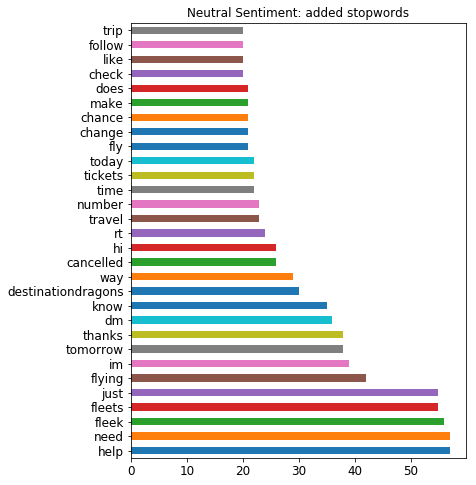

Index([u'help', u'need', u'fleek', u'fleets', u'just', u'flying', u'im',
       u'tomorrow', u'thanks', u'dm', u'know', u'destinationdragons', u'way',
       u'cancelled', u'hi', u'rt', u'travel', u'number', u'time', u'tickets',
       u'today', u'fly', u'change', u'chance', u'make', u'does', u'check',
       u'like', u'follow', u'trip'],
      dtype='object')


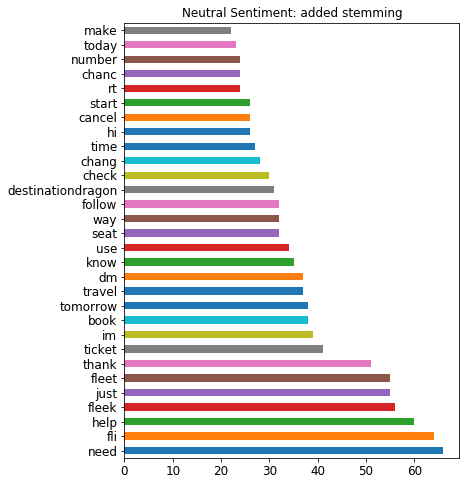

Index([u'need', u'fli', u'help', u'fleek', u'just', u'fleet', u'thank',
       u'ticket', u'im', u'book', u'tomorrow', u'travel', u'dm', u'know',
       u'use', u'seat', u'way', u'follow', u'destinationdragon', u'check',
       u'chang', u'time', u'hi', u'cancel', u'start', u'rt', u'chanc',
       u'number', u'today', u'make'],
      dtype='object')


In [101]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at bi-grams

In [102]:
grams = "Bigrams"

In [103]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(2,2))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(2,2))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(2,2))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [104]:
print(words_df.shape)
words_df.head(4)

(5656, 46578)


0162431184663 of  0167560070877 fsqthg  0214 when  \
airline_sentiment                                                      
neutral                           0                     0          0   
negative                          0                     0          0   
negative                          0                     0          0   
negative                          0                     0          0   

                   021mbps amp  02272015 737300  03 for  0510 in  0510 the  \
airline_sentiment                                                            
neutral                      0                0       0        0         0   
negative                     0                0       0        0         0   
negative                     0                0       0        0         0   
negative                     0                0       0        0         0   

                   0530 flight  0769 out     ...      zippers sorry  \
airline_sentiment                            ...                      
neutral                      0         0     ...                  0   
negative                     0         0     ...                  0   
negative                     0         0     ...                  0   
negative                     0         0     ...                  0   

                   zombie tomorrow  zone while  zone your  zones thanks  \
airline_sentiment                                                         
neutral                          0           0          0             0   
negative                         0           0          0             0   
negative                         0           0          0             0   
negative                         0           0          0             0   

                   zoom out  zrh departed  zukes nonvegan  zurich bc  \
airline_sentiment                                                      
neutral                   0             0               0          0   
negative                  0             0               0          0   
negative                  0             0               0          0   
negative                  0             0               0          0   

                   zurich why  
airline_sentiment              
neutral                     0  
negative                    0  
negative                    0  
negative                    0  

[4 rows x 46578 columns]

In [105]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5656, 33050)


0162431184663 agents  0167560070877 fsqthg  0214 started  \
airline_sentiment                                                             
neutral                               0                     0             0   

                   021mbps ended  02272015 737300  03 booking  0510 captain  \
airline_sentiment                                                             
neutral                        0                0           0             0   

                   0510 santo  0530 dfw  0769 lga      ...        \
airline_sentiment                                      ...         
neutral                     0         0         0      ...         

                   zippers sorry  zombie tomorrow  zone actually  zone forced  \
airline_sentiment                                                               
neutral                        0                0              0            0   

                   zones thanks  zoom scroll  zrh departed  zukes nonvegan  \
airline_sentiment                                                            
neutral                       0            0             0               0   

                   zurich bc  zurich credit  
airline_sentiment                            
neutral                    0              0  

[1 rows x 33050 columns]

In [106]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5656, 31550)


0162431184663 agent  0167560070877 fsqthg  0214 start  \
airline_sentiment                                                          
neutral                              0                     0           0   
negative                             0                     0           0   
negative                             0                     0           0   
negative                             0                     0           0   

                   021mbp end  02272015 737300  03 book  0510 captain  \
airline_sentiment                                                       
neutral                     0                0        0             0   
negative                    0                0        0             0   
negative                    0                0        0             0   
negative                    0                0        0             0   

                   0510 santo  0530 dfw  0769 lga      ...        \
airline_sentiment                                      ...         
neutral                     0         0         0      ...         
negative                    0         0         0      ...         
negative                    0         0         0      ...         
negative                    0         0         0      ...         

                   zipper sorri  zombi tomorrow  zone actual  zone forc  \
airline_sentiment                                                         
neutral                       0               0            0          0   
negative                      0               0            0          0   
negative                      0               0            0          0   
negative                      0               0            0          0   

                   zone thank  zoom scroll  zrh depart  zuke nonvegan  \
airline_sentiment                                                       
neutral                     0            0           0              0   
negative                    0            0           0              0   
negative                    0            0           0              0   
negative                    0            0           0              0   

                   zurich bc  zurich credit  
airline_sentiment                            
neutral                    0              0  
negative                   0              0  
negative                   0              0  
negative                   0              0  

[4 rows x 31550 columns]

In [107]:
# Feature dimension reduced from 47728 with cleaned text, to 35649 with stopwords and
# 34824 with stemming.

## Positive

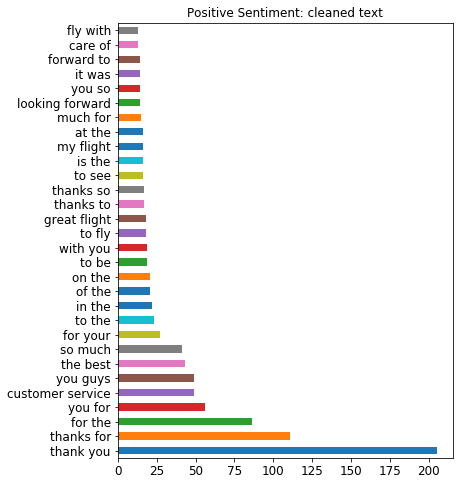

Index([u'thank you', u'thanks for', u'for the', u'you for',
       u'customer service', u'you guys', u'the best', u'so much', u'for your',
       u'to the', u'in the', u'of the', u'on the', u'to be', u'with you',
       u'to fly', u'great flight', u'thanks to', u'thanks so', u'to see',
       u'is the', u'my flight', u'at the', u'much for', u'looking forward',
       u'you so', u'it was', u'forward to', u'care of', u'fly with'],
      dtype='object')


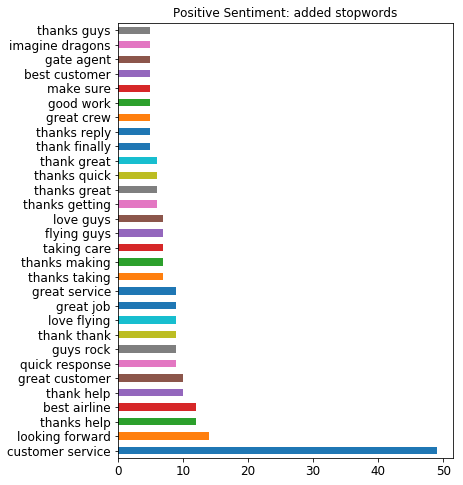

Index([u'customer service', u'looking forward', u'thanks help',
       u'best airline', u'thank help', u'great customer', u'quick response',
       u'guys rock', u'thank thank', u'love flying', u'great job',
       u'great service', u'thanks taking', u'thanks making', u'taking care',
       u'flying guys', u'love guys', u'thanks getting', u'thanks great',
       u'thanks quick', u'thank great', u'thank finally', u'thanks reply',
       u'great crew', u'good work', u'make sure', u'best customer',
       u'gate agent', u'imagine dragons', u'thanks guys'],
      dtype='object')


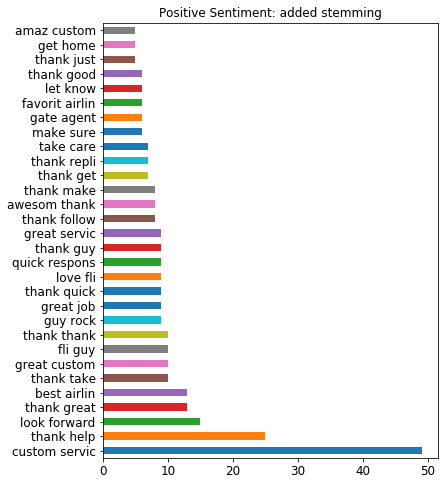

Index([u'custom servic', u'thank help', u'look forward', u'thank great',
       u'best airlin', u'thank take', u'great custom', u'fli guy',
       u'thank thank', u'guy rock', u'great job', u'thank quick', u'love fli',
       u'quick respons', u'thank guy', u'great servic', u'thank follow',
       u'awesom thank', u'thank make', u'thank get', u'thank repli',
       u'take care', u'make sure', u'gate agent', u'favorit airlin',
       u'let know', u'thank good', u'thank just', u'get home', u'amaz custom'],
      dtype='object')


In [108]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

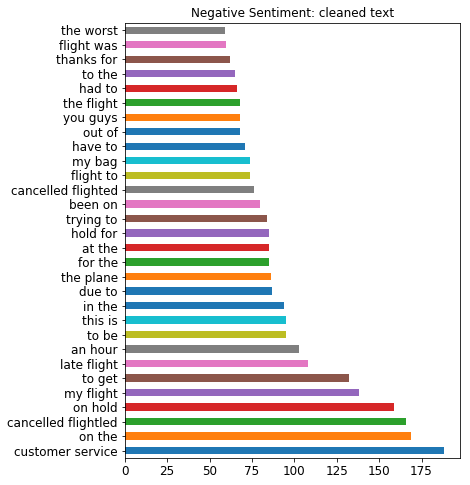

Index([u'customer service', u'on the', u'cancelled flightled', u'on hold',
       u'my flight', u'to get', u'late flight', u'an hour', u'to be',
       u'this is', u'in the', u'due to', u'the plane', u'for the', u'at the',
       u'hold for', u'trying to', u'been on', u'cancelled flighted',
       u'flight to', u'my bag', u'have to', u'out of', u'you guys',
       u'the flight', u'had to', u'to the', u'thanks for', u'flight was',
       u'the worst'],
      dtype='object')


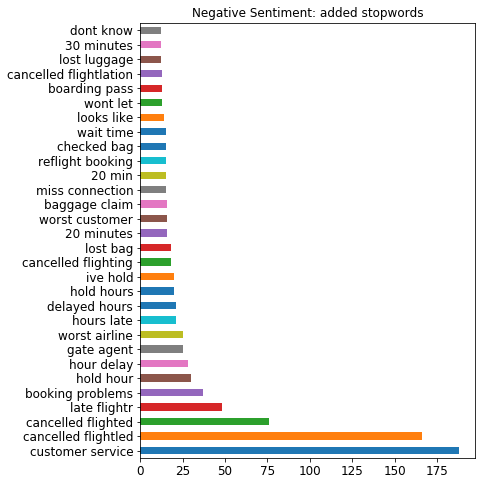

Index([u'customer service', u'cancelled flightled', u'cancelled flighted',
       u'late flightr', u'booking problems', u'hold hour', u'hour delay',
       u'gate agent', u'worst airline', u'hours late', u'delayed hours',
       u'hold hours', u'ive hold', u'cancelled flighting', u'lost bag',
       u'20 minutes', u'worst customer', u'baggage claim', u'miss connection',
       u'20 min', u'reflight booking', u'checked bag', u'wait time',
       u'looks like', u'wont let', u'boarding pass', u'cancelled flightlation',
       u'lost luggage', u'30 minutes', u'dont know'],
      dtype='object')


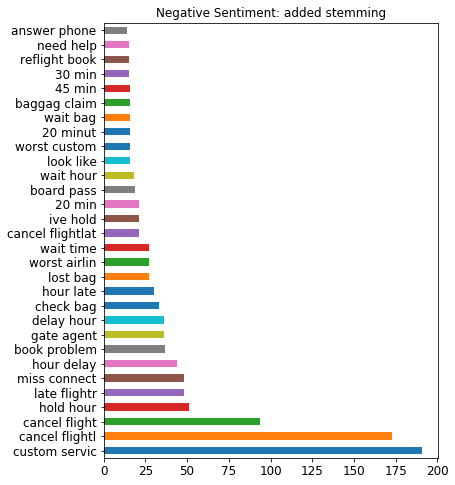

Index([u'custom servic', u'cancel flightl', u'cancel flight', u'hold hour',
       u'late flightr', u'miss connect', u'hour delay', u'book problem',
       u'gate agent', u'delay hour', u'check bag', u'hour late', u'lost bag',
       u'worst airlin', u'wait time', u'cancel flightlat', u'ive hold',
       u'20 min', u'board pass', u'wait hour', u'look like', u'worst custom',
       u'20 minut', u'wait bag', u'baggag claim', u'45 min', u'30 min',
       u'reflight book', u'need help', u'answer phone'],
      dtype='object')


In [109]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

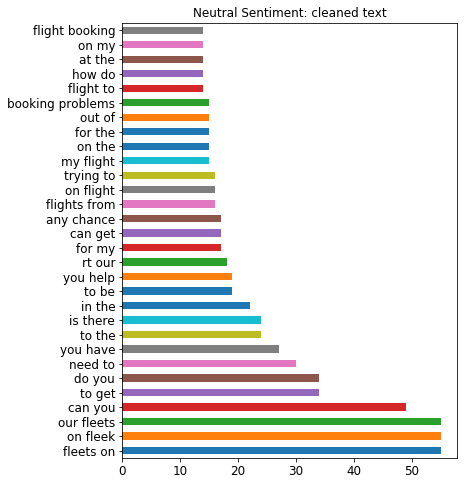

Index([u'fleets on', u'on fleek', u'our fleets', u'can you', u'to get',
       u'do you', u'need to', u'you have', u'to the', u'is there', u'in the',
       u'to be', u'you help', u'rt our', u'for my', u'can get', u'any chance',
       u'flights from', u'on flight', u'trying to', u'my flight', u'on the',
       u'for the', u'out of', u'booking problems', u'flight to', u'how do',
       u'at the', u'on my', u'flight booking'],
      dtype='object')


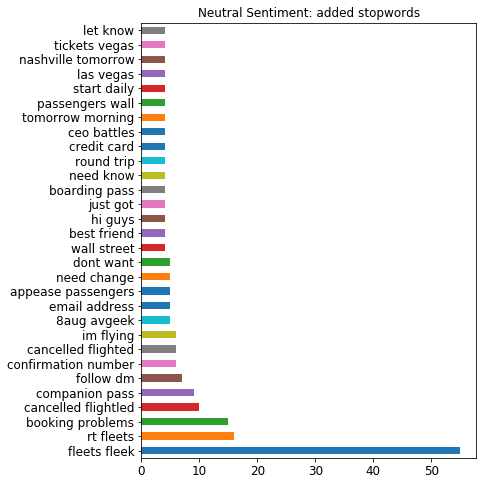

Index([u'fleets fleek', u'rt fleets', u'booking problems',
       u'cancelled flightled', u'companion pass', u'follow dm',
       u'confirmation number', u'cancelled flighted', u'im flying',
       u'8aug avgeek', u'email address', u'appease passengers', u'need change',
       u'dont want', u'wall street', u'best friend', u'hi guys', u'just got',
       u'boarding pass', u'need know', u'round trip', u'credit card',
       u'ceo battles', u'tomorrow morning', u'passengers wall', u'start daily',
       u'las vegas', u'nashville tomorrow', u'tickets vegas', u'let know'],
      dtype='object')


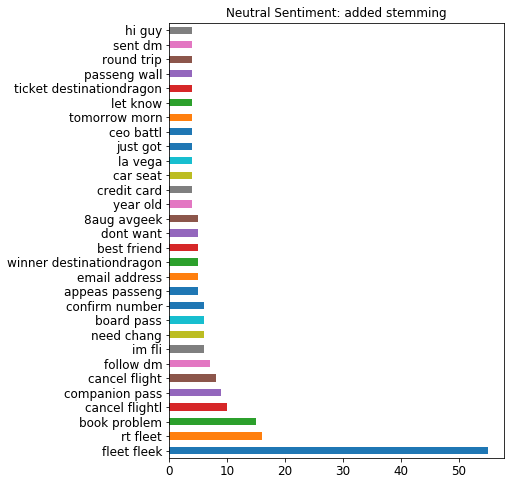

Index([u'fleet fleek', u'rt fleet', u'book problem', u'cancel flightl',
       u'companion pass', u'cancel flight', u'follow dm', u'im fli',
       u'need chang', u'board pass', u'confirm number', u'appeas passeng',
       u'email address', u'winner destinationdragon', u'best friend',
       u'dont want', u'8aug avgeek', u'year old', u'credit card', u'car seat',
       u'la vega', u'just got', u'ceo battl', u'tomorrow morn', u'let know',
       u'ticket destinationdragon', u'passeng wall', u'round trip', u'sent dm',
       u'hi guy'],
      dtype='object')


In [110]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at tri-grams

In [111]:
grams = "Trigrams"

In [112]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(3,3))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(3,3))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(3,3))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [113]:
# with stemming feature dimensionality reduced from 31667 to 31471.

In [114]:
print(words_df.shape)
words_df.head(1)

(5656, 68084)


0162431184663 of your  0167560070877 fsqthg thanks  \
airline_sentiment                                                       
neutral                                0                            0   

                   0214 when this  021mbps amp ended  03 for flight  \
airline_sentiment                                                     
neutral                         0                  0              0   

                   0510 in santo  0510 the captain  0530 flight out  \
airline_sentiment                                                     
neutral                        0                 0                0   

                   0769 out of  10 baggage claim        ...         \
airline_sentiment                                       ...          
neutral                      0                 0        ...          

                   zero to keep  zero to protect  \
airline_sentiment                                  
neutral                       0                0   

                   zero updates unitedairlinessux  zone while get  \
airline_sentiment                                                   
neutral                                         0               0   

                   zone your actually  zoom out or  zrh departed 245hrs  \
airline_sentiment                                                         
neutral                             0            0                    0   

                   zukes nonvegan yogurt  zurich bc of  zurich why would  
airline_sentiment                                                         
neutral                                0             0                 0  

[1 rows x 68084 columns]

In [115]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5656, 32957)


0162431184663 agents said  0167560070877 fsqthg thanks  \
airline_sentiment                                                           
neutral                                    0                            0   

                   0214 started phone  021mbps ended watching  \
airline_sentiment                                               
neutral                             0                       0   

                   03 booking problems  0510 captain informs  \
airline_sentiment                                              
neutral                              0                     0   

                   0510 santo domingo  0530 dfw tuesday  0769 lga dfw  \
airline_sentiment                                                       
neutral                             0                 0             0   

                   10 1115p construction         ...           \
airline_sentiment                                ...            
neutral                                0         ...            

                   zero meaningful assistance  zero people stepping  \
airline_sentiment                                                     
neutral                                     0                     0   

                   zero protect daughter  zero safealone plastic  \
airline_sentiment                                                  
neutral                                0                       0   

                   zero updates unitedairlinessux  zoom scroll touch  \
airline_sentiment                                                      
neutral                                         0                  0   

                   zrh departed 245hrs  zukes nonvegan yogurt  \
airline_sentiment                                               
neutral                              0                      0   

                   zurich bc fault  zurich credit miles  
airline_sentiment                                        
neutral                          0                    0  

[1 rows x 32957 columns]

In [116]:
print(words_stem_df.shape)
words_stem_df.head(1)

(5656, 32757)


0162431184663 agent said  0167560070877 fsqthg thank  \
airline_sentiment                                                         
neutral                                   0                           0   

                   0214 start phone  021mbp end watch  03 book problem  \
airline_sentiment                                                        
neutral                           0                 0                0   

                   0510 captain inform  0510 santo domingo  0530 dfw tuesday  \
airline_sentiment                                                              
neutral                              0                   0                 0   

                   0769 lga dfw  10 1115p construct         ...          \
airline_sentiment                                           ...           
neutral                       0                   0         ...           

                   zero meaning assist  zero peopl step  \
airline_sentiment                                         
neutral                              0                0   

                   zero protect daughter  zero safealon plastic  \
airline_sentiment                                                 
neutral                                0                      0   

                   zero updat unitedairlinessux  zoom scroll touch  \
airline_sentiment                                                    
neutral                                       0                  0   

                   zrh depart 245hr  zuke nonvegan yogurt  zurich bc fault  \
airline_sentiment                                                            
neutral                           0                     0                0   

                   zurich credit mile  
airline_sentiment                      
neutral                             0  

[1 rows x 32757 columns]

In [117]:
# dimensionality reduced from 72896, to 36572, 36269

## Positive

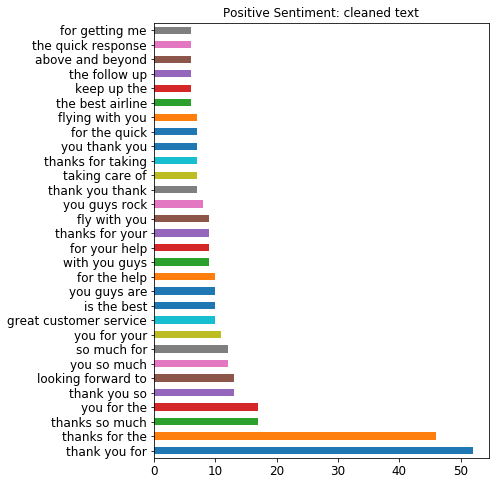

Index([u'thank you for', u'thanks for the', u'thanks so much', u'you for the',
       u'thank you so', u'looking forward to', u'you so much', u'so much for',
       u'you for your', u'great customer service', u'is the best',
       u'you guys are', u'for the help', u'with you guys', u'for your help',
       u'thanks for your', u'fly with you', u'you guys rock',
       u'thank you thank', u'taking care of', u'thanks for taking',
       u'you thank you', u'for the quick', u'flying with you',
       u'the best airline', u'keep up the', u'the follow up',
       u'above and beyond', u'the quick response', u'for getting me'],
      dtype='object')


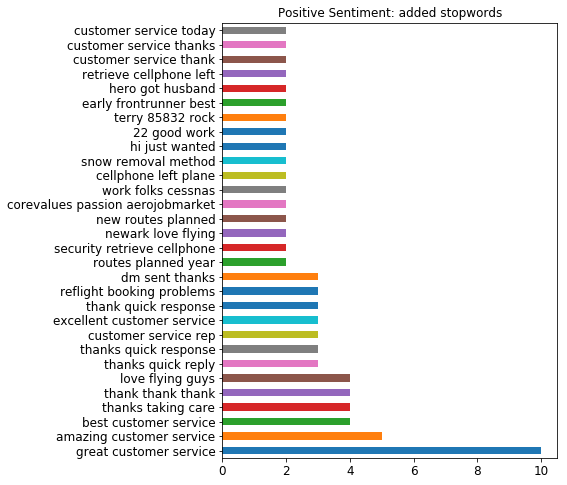

Index([u'great customer service', u'amazing customer service',
       u'best customer service', u'thanks taking care', u'thank thank thank',
       u'love flying guys', u'thanks quick reply', u'thanks quick response',
       u'customer service rep', u'excellent customer service',
       u'thank quick response', u'reflight booking problems',
       u'dm sent thanks', u'routes planned year',
       u'security retrieve cellphone', u'newark love flying',
       u'new routes planned', u'corevalues passion aerojobmarket',
       u'work folks cessnas', u'cellphone left plane', u'snow removal method',
       u'hi just wanted', u'22 good work', u'terry 85832 rock',
       u'early frontrunner best', u'hero got husband',
       u'retrieve cellphone left', u'customer service thank',
       u'customer service thanks', u'customer service today'],
      dtype='object')


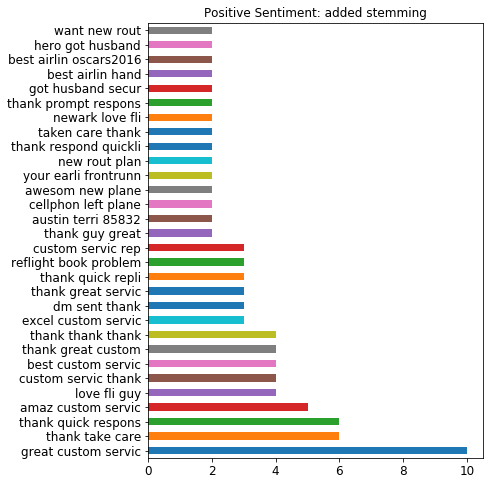

Index([u'great custom servic', u'thank take care', u'thank quick respons',
       u'amaz custom servic', u'love fli guy', u'custom servic thank',
       u'best custom servic', u'thank great custom', u'thank thank thank',
       u'excel custom servic', u'dm sent thank', u'thank great servic',
       u'thank quick repli', u'reflight book problem', u'custom servic rep',
       u'thank guy great', u'austin terri 85832', u'cellphon left plane',
       u'awesom new plane', u'your earli frontrunn', u'new rout plan',
       u'thank respond quickli', u'taken care thank', u'newark love fli',
       u'thank prompt respons', u'got husband secur', u'best airlin hand',
       u'best airlin oscars2016', u'hero got husband', u'want new rout'],
      dtype='object')


In [118]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

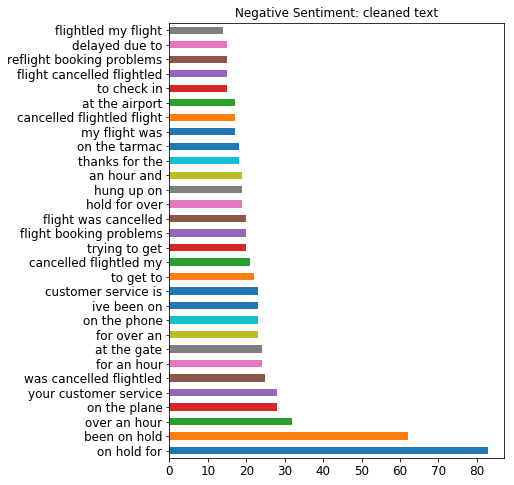

Index([u'on hold for', u'been on hold', u'over an hour', u'on the plane',
       u'your customer service', u'was cancelled flightled', u'for an hour',
       u'at the gate', u'for over an', u'on the phone', u'ive been on',
       u'customer service is', u'to get to', u'cancelled flightled my',
       u'trying to get', u'flight booking problems', u'flight was cancelled',
       u'hold for over', u'hung up on', u'an hour and', u'thanks for the',
       u'on the tarmac', u'my flight was', u'cancelled flightled flight',
       u'at the airport', u'to check in', u'flight cancelled flightled',
       u'reflight booking problems', u'delayed due to',
       u'flightled my flight'],
      dtype='object')


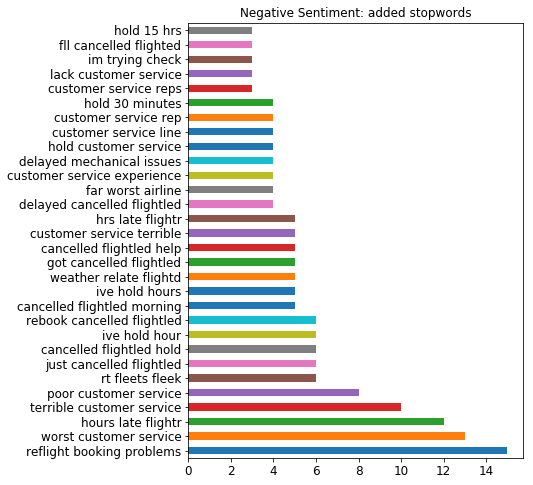

Index([u'reflight booking problems', u'worst customer service',
       u'hours late flightr', u'terrible customer service',
       u'poor customer service', u'rt fleets fleek',
       u'just cancelled flightled', u'cancelled flightled hold',
       u'ive hold hour', u'rebook cancelled flightled',
       u'cancelled flightled morning', u'ive hold hours',
       u'weather relate flightd', u'got cancelled flightled',
       u'cancelled flightled help', u'customer service terrible',
       u'hrs late flightr', u'delayed cancelled flightled',
       u'far worst airline', u'customer service experience',
       u'delayed mechanical issues', u'hold customer service',
       u'customer service line', u'customer service rep', u'hold 30 minutes',
       u'customer service reps', u'lack customer service', u'im trying check',
       u'fll cancelled flighted', u'hold 15 hrs'],
      dtype='object')


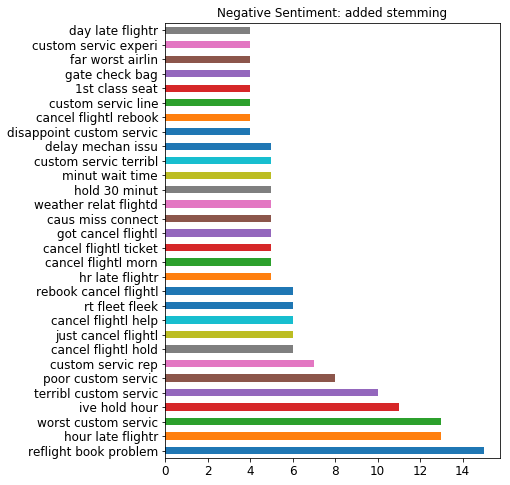

Index([u'reflight book problem', u'hour late flightr', u'worst custom servic',
       u'ive hold hour', u'terribl custom servic', u'poor custom servic',
       u'custom servic rep', u'cancel flightl hold', u'just cancel flightl',
       u'cancel flightl help', u'rt fleet fleek', u'rebook cancel flightl',
       u'hr late flightr', u'cancel flightl morn', u'cancel flightl ticket',
       u'got cancel flightl', u'caus miss connect', u'weather relat flightd',
       u'hold 30 minut', u'minut wait time', u'custom servic terribl',
       u'delay mechan issu', u'disappoint custom servic',
       u'cancel flightl rebook', u'custom servic line', u'1st class seat',
       u'gate check bag', u'far worst airlin', u'custom servic experi',
       u'day late flightr'],
      dtype='object')


In [119]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

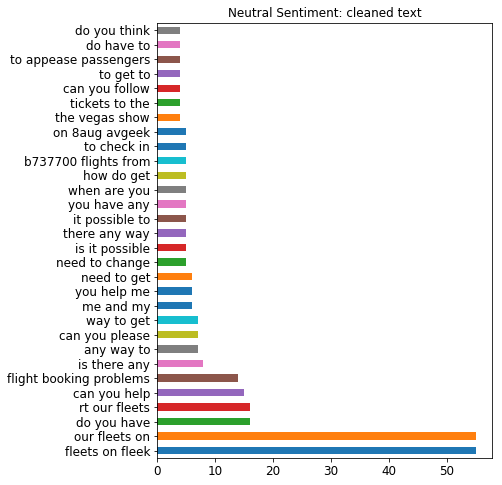

Index([u'fleets on fleek', u'our fleets on', u'do you have', u'rt our fleets',
       u'can you help', u'flight booking problems', u'is there any',
       u'any way to', u'can you please', u'way to get', u'me and my',
       u'you help me', u'need to get', u'need to change', u'is it possible',
       u'there any way', u'it possible to', u'you have any', u'when are you',
       u'how do get', u'b737700 flights from', u'to check in',
       u'on 8aug avgeek', u'the vegas show', u'tickets to the',
       u'can you follow', u'to get to', u'to appease passengers',
       u'do have to', u'do you think'],
      dtype='object')


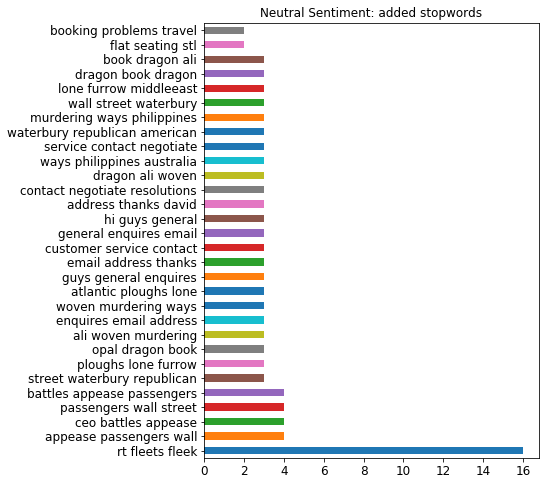

Index([u'rt fleets fleek', u'appease passengers wall', u'ceo battles appease',
       u'passengers wall street', u'battles appease passengers',
       u'street waterbury republican', u'ploughs lone furrow',
       u'opal dragon book', u'ali woven murdering', u'enquires email address',
       u'woven murdering ways', u'atlantic ploughs lone',
       u'guys general enquires', u'email address thanks',
       u'customer service contact', u'general enquires email',
       u'hi guys general', u'address thanks david',
       u'contact negotiate resolutions', u'dragon ali woven',
       u'ways philippines australia', u'service contact negotiate',
       u'waterbury republican american', u'murdering ways philippines',
       u'wall street waterbury', u'lone furrow middleeast',
       u'dragon book dragon', u'book dragon ali', u'flat seating stl',
       u'booking problems travel'],
      dtype='object')


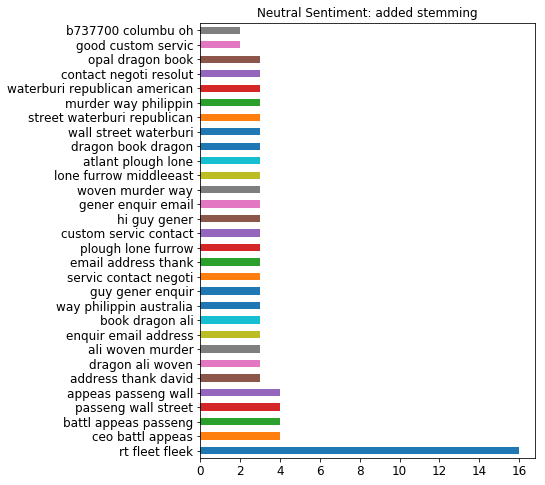

Index([u'rt fleet fleek', u'ceo battl appeas', u'battl appeas passeng',
       u'passeng wall street', u'appeas passeng wall', u'address thank david',
       u'dragon ali woven', u'ali woven murder', u'enquir email address',
       u'book dragon ali', u'way philippin australia', u'guy gener enquir',
       u'servic contact negoti', u'email address thank', u'plough lone furrow',
       u'custom servic contact', u'hi guy gener', u'gener enquir email',
       u'woven murder way', u'lone furrow middleeast', u'atlant plough lone',
       u'dragon book dragon', u'wall street waterburi',
       u'street waterburi republican', u'murder way philippin',
       u'waterburi republican american', u'contact negoti resolut',
       u'opal dragon book', u'good custom servic', u'b737700 columbu oh'],
      dtype='object')


In [120]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

In [121]:
# Pickle dataframe with added columns with processed and cleaned text.
import pickle

In [124]:
filename = data_out_dir+'airline_cl_process_dataset_df1'
filehandler = open(filename,"wb")
pickle.dump(air_sub_df,filehandler)

In [125]:
file = open(filename,'rb')
object_content = pickle.load(file)

In [127]:
type(object_content)

pandas.core.frame.DataFrame

In [128]:
object_content.columns, object_content.shape

(Index([u'text', u'airline_sentiment', u'airline_sentiment_confidence',
        u'negativereason', u'airline', u'clean_text', u'stopw_clean_text',
        u'stem_stopw_clean_text'],
       dtype='object'), (5656, 8))